In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

import re

In [2]:
data = pd.read_csv("Finance_data.csv")
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [3]:
data.Sentiment.value_counts()

neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64

In [4]:
data = data[data.Sentiment != "neutral"]

In [5]:
num_of_categories = 2000

shuffled = data.reindex(np.random.permutation(data.index))
positive = shuffled[shuffled['Sentiment'] == 'positive'][:num_of_categories]
negative = shuffled[shuffled['Sentiment'] == 'negative'][:num_of_categories]
concated = pd.concat([positive, negative], ignore_index=True)

#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['Label'] = 0

In [6]:
#One-hot encode the lab
concated.loc[concated['Sentiment'] == 'positive', 'Label'] = 0
concated.loc[concated['Sentiment'] == 'negative', 'Label'] = 1
print(concated['Label'][:10])

labels = to_categorical(concated['Label'], num_classes = 2)
#print(labels[:10])

if 'Sentiment' in concated.keys():
    concated.drop(['Sentiment'], axis=1)
'''
 [1. 0. 0.] positive
 [0. 1. 0.] negative
'''

2211    1
2307    1
406     0
96      0
1517    0
2267    1
2032    1
1416    0
208     0
1407    0
Name: Label, dtype: int64


'\n [1. 0. 0.] positive\n [0. 1. 0.] negative\n'

In [7]:
n_most_common_words = 10000
max_len = 130

tokenizer = Tokenizer(num_words = n_most_common_words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower = True)
tokenizer.fit_on_texts(concated['Sentence'].values)
sequences = tokenizer.texts_to_sequences(concated['Sentence'].values)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 7382 unique tokens.


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.20, random_state=56, stratify = data["Sentiment"])

In [9]:
#Hyperparameters
epochs = 25
emb_dim = 128
batch_size = 32
lstm_out = 128
#Dropout Values
#Activation Functions
#Loss Function

In [10]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

((2169, 130), (2169, 2), (543, 130), (543, 2))


In [11]:
model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(lstm_out, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

2023-04-09 00:38:30.282389: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 128)          1280000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 130, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 1,411,842
Trainable params: 1,411,842
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

Epoch 1/25
55/55 [==============================] - 123s 2s/step - loss: 0.6390 - acc: 0.6732 - val_loss: 0.6066 - val_acc: 0.7005
Epoch 2/25
55/55 [==============================] - 117s 2s/step - loss: 0.6229 - acc: 0.6784 - val_loss: 0.6057 - val_acc: 0.7005
Epoch 3/25
55/55 [==============================] - 115s 2s/step - loss: 0.5774 - acc: 0.6980 - val_loss: 0.5541 - val_acc: 0.7304
Epoch 4/25
55/55 [==============================] - 116s 2s/step - loss: 0.4877 - acc: 0.7637 - val_loss: 0.4671 - val_acc: 0.7903
Epoch 5/25
55/55 [==============================] - 116s 2s/step - loss: 0.3791 - acc: 0.8265 - val_loss: 0.4126 - val_acc: 0.8065
Epoch 6/25
55/55 [==============================] - 116s 2s/step - loss: 0.3075 - acc: 0.8732 - val_loss: 0.3851 - val_acc: 0.8272
Epoch 7/25
55/55 [==============================] - 117s 2s/step - loss: 0.2785 - acc: 0.8830 - val_loss: 0.3825 - val_acc: 0.8456
Epoch 8/25
55/55 [==============================] - 116s 2s/step - loss: 0.2273 - a

In [13]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

17/17 [==============================] - 4s 244ms/step - loss: 0.4549 - acc: 0.8158
Test set
  Loss: 0.455
  Accuracy: 0.816


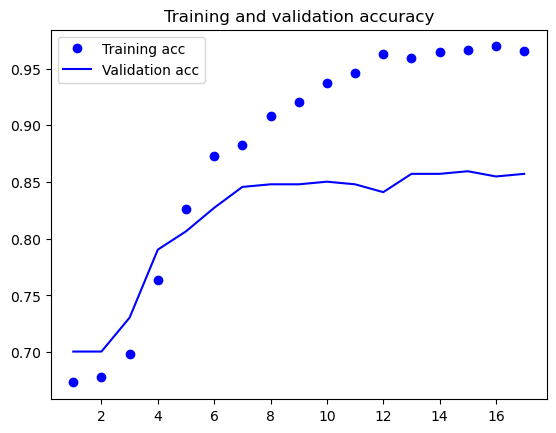

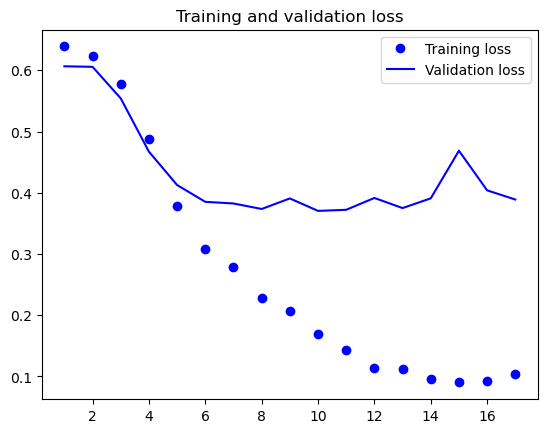

In [14]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
test_sent = ['Bro, Ive been waiting, dawg!']

#vectorizing the tweet by the pre-fitted tokenizer instance
test_sent = tokenizer.texts_to_sequences(test_sent)

#padding the tweet to have exactly the same shape as `embedding_2` input
test_sent = pad_sequences(test_sent, maxlen = max_len, dtype = 'int32', value = 0)

sentiment = model.predict(test_sent)

print("Actual output of model: ", sentiment)

if(np.argmax(sentiment) == 0):
    print("Sentence 1 has a positive sentiment.")
elif (np.argmax(sentiment) == 1):
    print("Sentence 1 has a negative sentiment")

1/1 [==============================] - 0s 455ms/step
Actual output of model:  [[0.46964064 0.5303593 ]]
Sentence 1 has a negative sentiment


In [17]:
test_sent2 = ['The stocks are going down. Everything is low!']
test_sent2 = tokenizer.texts_to_sequences(test_sent2)
test_sent2 = pad_sequences(test_sent2, maxlen = 128, dtype = 'int32', value = 0)
sentiment2 = model.predict(test_sent2)

print("Actual output of model: ", sentiment2)

if(np.argmax(sentiment2) == 0):
    print("Sentence 2 has a positive sentiment.")
elif (np.argmax(sentiment2) == 1):
    print("Sentence 2 has a negative sentiment")

1/1 [==============================] - 0s 445ms/step
Actual output of model:  [[9.872023e-06 9.999901e-01]]
Sentence 2 has a negative sentiment


In [18]:
test_sent3 = ['This is a positive sentence!']
test_sent3 = tokenizer.texts_to_sequences(test_sent3)
test_sent3 = pad_sequences(test_sent3, maxlen = 128, dtype = 'int32', value = 0)
sentiment3 = model.predict(test_sent3)

print("Actual output of model: ", sentiment3)

if(np.argmax(sentiment3) == 0):
    print("Sentence 3 has a positive sentiment.")
elif (np.argmax(sentiment3) == 1):
    print("Sentence 3 has a negative sentiment")

1/1 [==============================] - 0s 83ms/step
Actual output of model:  [[0.99776256 0.00223742]]
Sentence 3 has a positive sentiment.


In [19]:
test = pd.read_csv('sampled2.csv')
test.head()

,Sentence,Sentiment
0,When TSLA was at 1K share price :\r\n\r\n8B sa...,positive
1,$TSLA will go down because you own the stock… ...,positive
2,TSLA 🚀🚀🚀🚀🚀🚀🚀,neutral
3,"&gt;What I mean is when I started investing, t...",positive
4,"I do trade in some ETFs.. DIV, SDIV ; USOI (it...",negative


In [20]:
test = test[test.Sentiment != "neutral"]

sentence = test['Sentence'].tolist()
sentiment = test['Sentiment'].tolist()

In [22]:
i = 0
correct = 0
for i in range(87):
    test = sentence[i]
    test = tokenizer.texts_to_sequences(test)
    test = pad_sequences(test, maxlen = 128, dtype = 'int32', value = 0)
    sentiment_t = model.predict(test)[0]
    
    actual = sentiment[i]
    
    if(np.argmax(sentiment_t) == 0):
        predicted = "negative"
    elif (np.argmax(sentiment_t) == 1):
        predicted = "positive"
    
    if(predicted == actual):
        correct += 1
    
    print(i)

6/6 [==============================] - 1s 201ms/step
0
9/9 [==============================] - 2s 238ms/step
1
10/10 [==============================] - 2s 243ms/step
2
16/16 [==============================] - 4s 233ms/step
3
4/4 [==============================] - 1s 235ms/step
4
6/6 [==============================] - 1s 203ms/step
5
2/2 [==============================] - 0s 190ms/step
6
14/14 [==============================] - 3s 238ms/step
7
9/9 [==============================] - 2s 238ms/step
8
2/2 [==============================] - 0s 182ms/step
9
5/5 [==============================] - 1s 226ms/step
10
10/10 [==============================] - 2s 232ms/step
11
4/4 [==============================] - 1s 204ms/step
12
15/15 [==============================] - 4s 236ms/step
13
4/4 [==============================] - 1s 230ms/step
14
2/2 [==============================] - 0s 207ms/step
15
4/4 [==============================] - 1s 199ms/step
16
5/5 [==============================] - 1s 204ms/

In [23]:
print("Number of correct predictions: ", correct)
print("Total predictions made: ", len(sentence))

Number of correct predictions:  48
Total predictions made:  87
